# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [ ]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [2]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = web.DataReader("AAPL", "yahoo", "2021-01-01", "2022-03-31")
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,128.453445
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,130.041626
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.664215
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.952286
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,131.073929
...,...,...,...,...,...,...
2022-03-25,175.279999,172.750000,173.880005,174.720001,80546200.0,174.720001
2022-03-28,175.729996,172.000000,172.169998,175.600006,90371900.0,175.600006
2022-03-29,179.009995,176.339996,176.690002,178.960007,100589400.0,178.960007


In [4]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,314.000000,314.000000,314.000000,314.000000,3.140000e+02,314.000000
mean,147.851943,144.687547,146.225637,146.354968,9.149200e+07,145.892812
std,17.506210,16.987672,17.189433,17.295963,2.780823e+07,17.523251
min,120.400002,116.209999,119.029999,116.360001,4.100000e+07,115.672493
25%,132.505005,129.472500,130.935005,131.295006,7.158792e+07,130.519272
50%,146.959999,144.605003,145.595001,145.860001,8.831780e+07,145.457115
75%,162.644997,157.757504,159.885006,160.197506,1.055171e+08,160.061531
max,182.940002,179.119995,182.630005,182.009995,1.954327e+08,181.778397


In [5]:
names = ["FB", "AAPL", "AMZN"]
# fechas en "yyyy-mm-dd"
start =     "2016-01-01"
end =       "2021-01-01"

In [6]:
def getClose(name, start, end) :
    return web.DataReader(name, "yahoo", start, end)["Adj Close"]

In [7]:
data = getClose(names, start, end)
data.head()

Symbols,FB,AAPL,AMZN
Date,,,
2016-01-04,102.220001,24.220577,636.989990
2016-01-05,102.730003,23.613630,633.789978
2016-01-06,102.970001,23.151512,632.650024
2016-01-07,97.919998,22.174412,607.940002
2016-01-08,97.330002,22.291670,607.049988


In [8]:
data.describe()

Symbols,FB,AAPL,AMZN
count,1259.000000,1259.000000,1259.000000
mean,172.324805,50.218453,1557.184304
std,44.300627,26.280226,745.735378
min,94.160004,21.009537,482.070007
25%,137.824997,33.474014,889.024994
50%,171.580002,42.349609,1607.949951
75%,192.404999,55.245436,1884.440002
max,303.910004,135.679642,3531.449951


<AxesSubplot:xlabel='Date'>

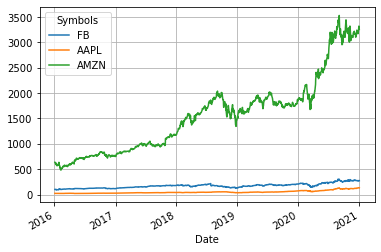

In [9]:
data.plot(grid=True)

array([[<AxesSubplot:title={'center':'FB'}>,
        <AxesSubplot:title={'center':'AAPL'}>],
       [<AxesSubplot:title={'center':'AMZN'}>, <AxesSubplot:>]],
      dtype=object)

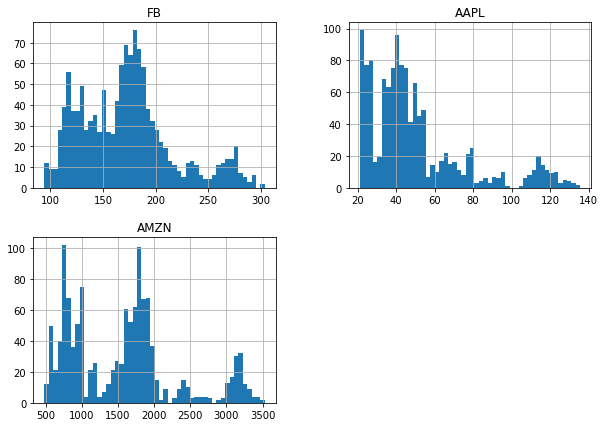

In [10]:
data.hist(bins=50, figsize=(10, 7))

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [11]:
R = ((data - data.shift())/data.shift()).dropna()
r = (np.log(data) - np.log(data.shift())).dropna()

<AxesSubplot:xlabel='Date'>

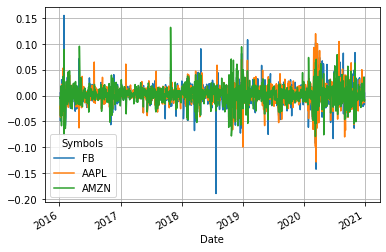

In [12]:
R.plot(grid=True)

<AxesSubplot:xlabel='Date'>

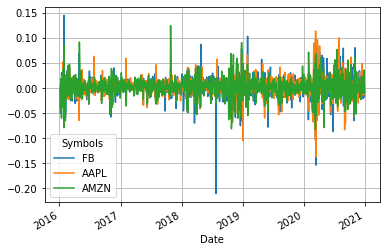

In [13]:
r.plot(grid=True)

array([[<AxesSubplot:title={'center':'FB'}>,
        <AxesSubplot:title={'center':'AAPL'}>],
       [<AxesSubplot:title={'center':'AMZN'}>, <AxesSubplot:>]],
      dtype=object)

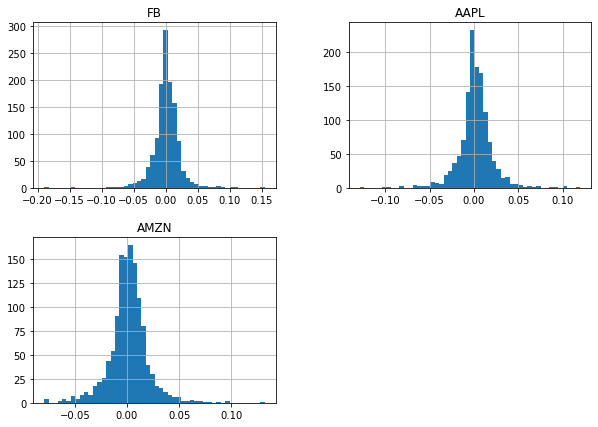

In [14]:
R.hist(bins=50, figsize=(10, 7))

In [15]:
R.describe()

Symbols,FB,AAPL,AMZN
count,1258.000000,1258.000000,1258.000000
mean,0.000998,0.001528,0.001479
std,0.020753,0.019009,0.019099
min,-0.189609,-0.128647,-0.079221
25%,-0.007384,-0.005891,-0.006786
50%,0.001174,0.001057,0.001451
75%,0.010856,0.010156,0.010648
max,0.155214,0.119809,0.132164


In [16]:
pd.date_range?

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [17]:
# Asumimos que los rendimientos presentan una distribución normal
media_FB = R["FB"].mean()
std_FB   = R["FB"].std()
media_FB, std_FB

(0.0009983677918969796, 0.020752866788226673)

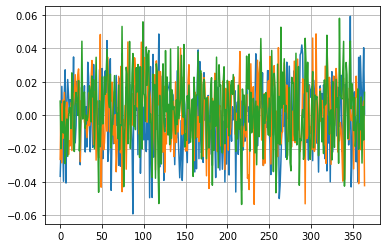

In [18]:
R_simulados = np.random.normal(media_FB, std_FB, size=(365, 3))
plt.figure()
plt.plot(R_simulados)
plt.grid()

In [19]:
fechas = pd.date_range("2021-01-02", periods=365)
R_simulados_2021 = pd.DataFrame(data=R_simulados, index=fechas)
R_simulados_2021

,0,1,2
2021-01-02,-0.036573,-0.026421,0.008458
2021-01-03,-0.019949,0.006904,-0.020079
2021-01-04,0.017290,-0.028507,-0.003760
2021-01-05,-0.012483,0.009122,-0.009476
2021-01-06,-0.039534,-0.013703,-0.010666
...,...,...,...
2021-12-28,0.018011,0.006647,0.010962
2021-12-29,0.000531,-0.003505,-0.028639
2021-12-30,0.014945,0.003485,0.005184
2021-12-31,0.040446,0.008501,-0.014823


Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [32]:
np.random.seed(20)
def simR(media, std, start, dias, N) :
    R_simulado = np.random.normal(media, std, size=(dias, N))
    fechas = pd.date_range(start, periods=dias)
    return pd.DataFrame(data=R_simulado, index=fechas)
rendimientos_simulados = simR(media_FB, std_FB, "2021-01-02", 1000, 1000)
rendimientos_simulados

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2021-01-02,0.019342,0.005063,0.008418,-0.047631,-0.021515,0.012614,0.020495,-0.019308,0.011439,0.009433,...,0.012287,-0.016439,-0.045240,-0.017547,0.025449,-0.015016,-0.016402,0.000705,0.044109,0.010475
2021-01-03,0.003937,-0.010415,0.024538,0.017425,0.000264,-0.003049,-0.020547,0.010210,0.020935,-0.007933,...,0.008401,-0.032685,0.031288,0.009266,-0.000474,-0.032868,-0.005524,-0.003333,-0.000794,-0.020882
2021-01-04,0.026377,-0.009301,-0.036960,0.003506,0.007247,0.047997,-0.015704,0.016433,0.029928,-0.005744,...,0.008895,-0.038142,0.005993,0.042368,0.028491,0.010369,0.022561,-0.017723,-0.010072,0.015220
2021-01-05,0.001559,-0.009764,0.013050,0.015535,-0.008348,0.013250,0.046264,-0.006798,0.046940,0.027848,...,0.032246,-0.011578,-0.014564,0.003541,-0.028188,-0.007204,0.017823,0.011949,0.002913,0.015305
2021-01-06,0.023367,0.027908,-0.012858,0.029067,-0.007983,-0.006625,0.003197,0.011026,0.040178,-0.021787,...,0.005677,-0.001550,-0.023494,-0.030835,-0.008915,0.023279,0.005642,-0.039713,-0.014342,0.004723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24,-0.016411,0.009190,-0.001282,0.034422,-0.016328,-0.002095,0.028385,0.029791,0.010700,0.027441,...,0.013870,-0.001702,-0.018198,0.001737,0.018621,0.031567,-0.017548,0.009798,0.025579,0.007606
2023-09-25,-0.008378,0.014867,0.027580,0.010936,-0.027377,-0.032637,-0.017384,-0.008817,0.006532,0.001992,...,0.030362,0.020432,-0.024285,0.001566,-0.017461,0.024245,-0.045745,-0.017825,0.002574,0.010037
2023-09-26,-0.008735,0.005942,0.038422,0.021987,-0.020826,-0.024669,-0.007983,0.008010,0.006902,0.030440,...,0.010945,-0.022493,0.010498,-0.047255,0.012720,-0.003656,0.002051,0.000088,-0.012552,0.000796
2023-09-27,-0.032264,0.007527,-0.007210,0.002744,-0.013411,-0.004825,0.012340,-0.003708,-0.013512,-0.003570,...,-0.014024,-0.009569,-0.005576,0.018338,0.016442,-0.065841,-0.000854,0.001832,-0.002459,0.014225


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [21]:
(rendimientos_simulados + 1).head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2021-01-02,1.019342,1.005063,1.008418,0.952369,0.978485,1.012614,1.020495,0.980692,1.011439,1.009433,...,1.012287,0.983561,0.954760,0.982453,1.025449,0.984984,0.983598,1.000705,1.044109,1.010475
2021-01-03,1.003937,0.989585,1.024538,1.017425,1.000264,0.996951,0.979453,1.010210,1.020935,0.992067,...,1.008401,0.967315,1.031288,1.009266,0.999526,0.967132,0.994476,0.996667,0.999206,0.979118
2021-01-04,1.026377,0.990699,0.963040,1.003506,1.007247,1.047997,0.984296,1.016433,1.029928,0.994256,...,1.008895,0.961858,1.005993,1.042368,1.028491,1.010369,1.022561,0.982277,0.989928,1.015220
2021-01-05,1.001559,0.990236,1.013050,1.015535,0.991652,1.013250,1.046264,0.993202,1.046940,1.027848,...,1.032246,0.988422,0.985436,1.003541,0.971812,0.992796,1.017823,1.011949,1.002913,1.015305
2021-01-06,1.023367,1.027908,0.987142,1.029067,0.992017,0.993375,1.003197,1.011026,1.040178,0.978213,...,1.005677,0.998450,0.976506,0.969165,0.991085,1.023279,1.005642,0.960287,0.985658,1.004723


In [22]:
# producto acumulado
rendimiento_acumulado = (rendimientos_simulados + 1).cumprod()
rendimiento_acumulado

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2021-01-02,1.019342,1.005063,1.008418,0.952369,0.978485,1.012614,1.020495,0.980692,1.011439,1.009433,...,1.012287,0.983561,0.954760,0.982453,1.025449,0.984984,0.983598,1.000705,1.044109,1.010475
2021-01-03,1.023355,0.994596,1.033163,0.968964,0.978743,1.009526,0.999527,0.990705,1.032613,1.001425,...,1.020791,0.951414,0.984632,0.991556,1.024963,0.952609,0.978165,0.997370,1.043281,0.989374
2021-01-04,1.050348,0.985345,0.994977,0.972361,0.985836,1.057981,0.983830,1.006985,1.063517,0.995673,...,1.029870,0.915125,0.990533,1.033567,1.054165,0.962487,1.000234,0.979694,1.032773,1.004433
2021-01-05,1.051986,0.975724,1.007961,0.987466,0.977607,1.071999,1.029346,1.000140,1.113439,1.023401,...,1.063079,0.904530,0.976107,1.037227,1.024451,0.955553,1.018061,0.991400,1.035781,1.019806
2021-01-06,1.076568,1.002954,0.995000,1.016169,0.969802,1.064897,1.032637,1.011167,1.158174,1.001104,...,1.069114,0.903128,0.953175,1.005244,1.015318,0.977797,1.023805,0.952029,1.020926,1.024623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24,1.052216,4.817337,2.121615,2.238690,2.658564,1.176428,4.241590,1.389803,2.187400,4.570839,...,2.596816,3.407618,2.384454,2.311041,3.716016,0.553119,1.369017,2.797887,4.369928,7.965940
2023-09-25,1.043400,4.888955,2.180129,2.263173,2.585781,1.138033,4.167853,1.377550,2.201689,4.579946,...,2.675659,3.477241,2.326547,2.314659,3.651129,0.566529,1.306391,2.748015,4.381174,8.045893
2023-09-26,1.034286,4.918006,2.263894,2.312933,2.531929,1.109959,4.134582,1.388584,2.216885,4.719358,...,2.704945,3.399027,2.350971,2.205280,3.697573,0.564458,1.309070,2.748256,4.326180,8.052294
2023-09-27,1.000916,4.955024,2.247572,2.319279,2.497974,1.104604,4.185601,1.383436,2.186931,4.702508,...,2.667011,3.366502,2.337861,2.245721,3.758370,0.527293,1.307953,2.753291,4.315540,8.166835


In [23]:
valores_simulados = (data["FB"].iloc[-1] * rendimiento_acumulado)
valores_simulados.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2021-01-02,278.443378,274.543048,275.459540,260.149110,267.282961,276.605554,278.758432,267.885852,276.284700,275.736622,...,276.516215,268.669520,260.802186,268.366886,280.111746,269.058303,268.679631,273.352640,285.208922,276.021312
2021-01-03,279.539615,271.683787,282.218822,264.682246,267.353499,275.762215,273.030778,270.621013,282.068670,273.549229,...,278.839199,259.888183,268.962115,270.853463,279.979014,260.214778,267.195522,272.441619,284.982519,270.257535
2021-01-04,286.913051,269.156728,271.787955,265.610151,269.290943,288.998021,268.743028,275.068141,290.510330,271.978088,...,281.319348,249.975623,270.574089,282.329070,287.955820,262.912882,273.223799,267.613122,282.112196,274.370957
2021-01-05,287.360387,266.528646,275.334717,269.736306,267.043009,292.827210,281.176236,273.198319,304.146979,279.552139,...,290.390648,247.081517,266.633455,283.328828,279.839005,261.018809,278.093561,270.810889,282.933973,278.570285
2021-01-06,294.075209,273.967027,271.794333,277.576712,264.911163,290.887182,282.075232,276.210494,316.366923,273.461612,...,292.039210,246.698426,260.369166,274.592336,277.344160,267.095116,279.662602,260.056270,278.876171,279.886035


## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [24]:
valor_deseado = data["FB"].iloc[-1]*1.20
data["FB"].iloc[-1], valor_deseado

(273.1600036621094, 327.79200439453126)

In [25]:
sobrepasa_el_deseado = (valores_simulados >= valor_deseado)
sobrepasa_el_deseado

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2021-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-01-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24,False,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
2023-09-25,False,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
2023-09-26,False,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
2023-09-27,False,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True


In [26]:
probabilidad_de_sobrepasar = sobrepasa_el_deseado.mean(axis=1)
probabilidad_de_sobrepasar

2021-01-02    0.000
2021-01-03    0.000
2021-01-04    0.000
2021-01-05    0.000
2021-01-06    0.000
              ...  
2023-09-24    0.825
2023-09-25    0.823
2023-09-26    0.827
2023-09-27    0.822
2023-09-28    0.822
Freq: D, Length: 1000, dtype: float64

<AxesSubplot:>

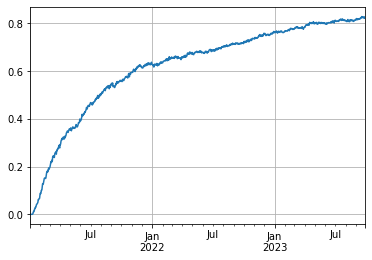

In [27]:
probabilidad_de_sobrepasar.plot(grid=True)

In [28]:
data["AAPL"].iloc[-1]

131.70921325683594

<AxesSubplot:>

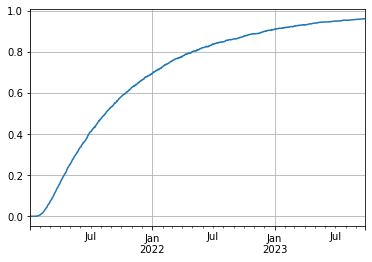

In [33]:
# Rendimientos
R_AAPL = R["AAPL"]
# Rendimientos simulados
RS_AAPL = simR(R_AAPL.mean(), R_AAPL.std(), "2021-01-02", 1000, 10000)
# Rendimientos simulados acumulados
RSa_AAPL = (RS_AAPL + 1).cumprod()
# Valores simulados
VS_AAPL = data["AAPL"].iloc[-1]*RSa_AAPL

valor_deseado = data["AAPL"].iloc[-1]*1.35
B_AAPL = VS_AAPL >= valor_deseado
P_AAPL = B_AAPL.mean(axis=1)
P_AAPL.plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.